**This notebook is for twitter tweets sentiment analysis using RNN Models****

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from textblob import TextBlob
import emoji
import unicodedata

In [2]:
data = pd.read_csv(r'/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv', encoding='latin1', header=None)

In [3]:
dt = data[[0, 5]]
dt.columns = ['target', 'text']
dt

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,4,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...


In [4]:
dt['target'].value_counts()

target
0    800000
4    800000
Name: count, dtype: int64

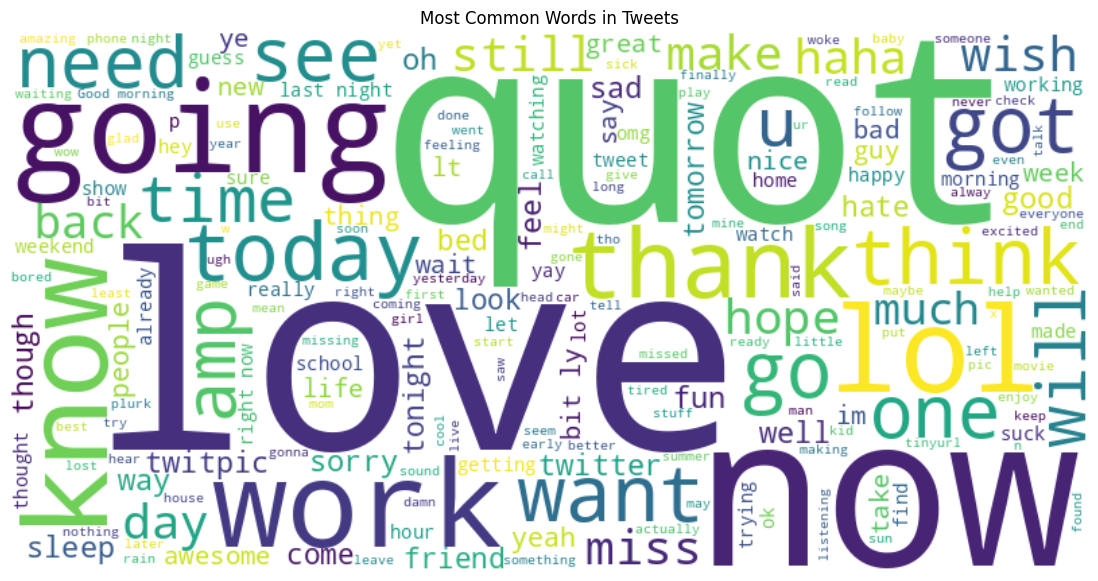

In [5]:
from wordcloud import WordCloud

text = ' '.join(dt['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Tweets')
plt.show()


/tmp/ipykernel_36/1792125742.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt['text_length'] = dt['text'].apply(lambda x: len(x.split()))
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


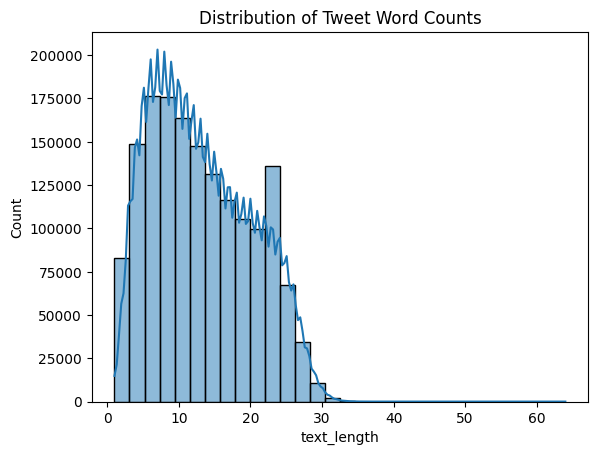

In [6]:
dt['text_length'] = dt['text'].apply(lambda x: len(x.split()))
sns.histplot(dt['text_length'], bins=30, kde=True)
plt.title('Distribution of Tweet Word Counts')
plt.show()

The above two plots were to see avgerage length and most used words for embedding layer

In [7]:
dt.drop('text_length',axis=1)

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,4,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...


In [8]:
dt['text'].str.lower()

0          @switchfoot http://twitpic.com/2y1zl - awww, t...
1          is upset that he can't update his facebook by ...
2          @kenichan i dived many times for the ball. man...
3            my whole body feels itchy and like its on fire 
4          @nationwideclass no, it's not behaving at all....
                                 ...                        
1599995    just woke up. having no school is the best fee...
1599996    thewdb.com - very cool to hear old walt interv...
1599997    are you ready for your mojo makeover? ask me f...
1599998    happy 38th birthday to my boo of alll time!!! ...
1599999    happy #charitytuesday @thenspcc @sparkscharity...
Name: text, Length: 1600000, dtype: object

In [9]:
slang_text="""AFAIK=As Far As I Know
AFK=Away From Keyboard
ASAP=As Soon As Possible
ATK=At The Keyboard
ATM=At The Moment
A3=Anytime, Anywhere, Anyplace
BAK=Back At Keyboard
BBL=Be Back Later
BBS=Be Back Soon
BFN=Bye For Now
B4N=Bye For Now
BRB=Be Right Back
BRT=Be Right There
BTW=By The Way
B4=Before
B4N=Bye For Now
CU=See You
CUL8R=See You Later
CYA=See You
FAQ=Frequently Asked Questions
FC=Fingers Crossed
FWIW=For What It is Worth
FYI=For Your Information
GAL=Get A Life
GG=Good Game
GN=Good Night
GMTA=Great Minds Think Alike
GR8=Great!
G9=Genius
IC=I See
ICQ=I Seek you (also a chat program)
ILU=ILU: I Love You
IMHO=In My Honest/Humble Opinion
IMO=In My Opinion
IOW=In Other Words
IRL=In Real Life
KISS=Keep It Simple, Stupid
LDR=Long Distance Relationship
LMAO=Laugh My A.. Off
LOL=Laughing Out Loud
LTNS=Long Time No See
L8R=Later
MTE=My Thoughts Exactly
M8=Mate
NRN=No Reply Necessary
OIC=Oh I See
PITA=Pain In The A..
PRT=Party
PRW=Parents Are Watching
QPSA?	Que Pasa?
ROFL=Rolling On The Floor Laughing
ROFLOL=Rolling On The Floor Laughing Out Loud
ROTFLMAO=Rolling On The Floor Laughing My A.. Off
SK8=Skate
STATS=Your sex and age
ASL=Age, Sex, Location
THX=Thank You
TTFN=Ta-Ta For Now!
TTYL=Talk To You Later
U=You
U2=You Too
U4E=Yours For Ever
WB=Welcome Back
WTF=What The F...
WTG=Way To Go!
WUF=Where Are You From?
W8=Wait...
7K=Sick:-D Laugher
TFW – That feeling when. TFW internet slang often goes in a caption to an image.
MFW – My face when
MRW – My reaction when
IFYP – I feel your pain
LOL – Laughing out loud
TNTL – Trying not to laugh
JK – Just kidding
IDC – I don’t care
ILY – I love you
IMU – I miss you
ADIH – Another day in hell
IDC – I don’t care
ZZZ – Sleeping, bored, tired
WYWH – Wish you were here
TIME – Tears in my eyes
BAE – Before anyone else
FIMH – Forever in my heart
BSAAW – Big smile and a wink
BWL – Bursting with laughter
LMAO – Laughing my a** off
BFF: Best friends forever
CSL – Can’t stop laughing"""

This is the slang word dictionary I downloaded from github

In [10]:
chat_words = {}
for line in slang_text.strip().split('\n'):
    if '=' in line:
        key, value = line.strip().split('=', 1)
        chat_words[key.strip()] = value.strip()
print(list(chat_words.items())[:10])

[('AFAIK', 'As Far As I Know'), ('AFK', 'Away From Keyboard'), ('ASAP', 'As Soon As Possible'), ('ATK', 'At The Keyboard'), ('ATM', 'At The Moment'), ('A3', 'Anytime, Anywhere, Anyplace'), ('BAK', 'Back At Keyboard'), ('BBL', 'Be Back Later'), ('BBS', 'Be Back Soon'), ('BFN', 'Bye For Now')]


In [11]:
def preprocess(text):
    text=re.sub(r'http\S+|www.\S+', ' ', text)#url
    text=re.sub(r'@\w+', ' ', text)#mention
    text=re.sub(r'#',' ',text)#hashtag only
    text=re.sub(r'\d+',' ',text)#digits
    text=re.sub(r'[^\w\s]', ' ', text)#anything except wordand spaces-removing punctuations
    text=re.sub(r'\s+', ' ', text).strip()#removing multiple spaces and before and after sentence spaces
    text=re.sub(r'(.)\1{2,}', r'\1\1', text)
    # text = str(TextBlob(text).correct())
    text = emoji.demojize(text)
    text=unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode("utf-8", "ignore")
    words = text.split()
    cleaned_words = [word for word in words if word not in stop_words]
    text = ' '.join(cleaned_words)#removing stopwords
    text = ' '.join([chat_words.get(w.upper(), w) for w in words])#chatwords
    text.lower()
    return text

This was my nlp preprocessing function with all possible ways to clean

In [12]:
from tqdm import tqdm
tqdm.pandas()
dt.loc[:,'text']=dt['text'].progress_apply(preprocess)

100%|██████████| 1600000/1600000 [01:45<00:00, 15135.14it/s]


In [13]:
dt.info

<bound method DataFrame.info of          target                                               text  \
0             0  Aww that s a bummer You shoulda got David Carr...   
1             0  is upset that he can t update his Facebook by ...   
2             0  I dived many times for the ball Managed to sav...   
3             0     my whole body feels itchy and like its on fire   
4             0  no it s not behaving at all i m mad why am i h...   
...         ...                                                ...   
1599995       4  Just woke up Having no school is the best feel...   
1599996       4  TheWDB com Very cool to hear old Walt intervie...   
1599997       4  Are you ready for your MoJo Makeover Ask me fo...   
1599998       4  Happy th Birthday to my boo of all time Tupac ...   
1599999       4                               happy charitytuesday   

         text_length  
0                 19  
1                 21  
2                 18  
3                 10  
4           

In [14]:
null = dt[dt['text'] == '']

In [15]:
len(null)

3226

In [16]:
dt = dt[dt['text'].notnull() & (dt['text'].str.strip() != '')].reset_index(drop=True)

In [17]:
null_chk = dt[dt['text'] == '']

In [18]:
len(null_chk)

0

After cleaning the data some were reduced to '' or null so I removed those sentences adn reset the index

In [19]:
dt['text'].str.lower()

0          aww that s a bummer you shoulda got david carr...
1          is upset that he can t update his facebook by ...
2          i dived many times for the ball managed to sav...
3             my whole body feels itchy and like its on fire
4          no it s not behaving at all i m mad why am i h...
                                 ...                        
1596769    just woke up having no school is the best feel...
1596770    thewdb com very cool to hear old walt intervie...
1596771    are you ready for your mojo makeover ask me fo...
1596772    happy th birthday to my boo of all time tupac ...
1596773                                 happy charitytuesday
Name: text, Length: 1596774, dtype: object

In [20]:
import tensorflow as tf


2025-07-13 11:08:12.774161: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752404892.945698      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752404892.997039      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [25]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer=Tokenizer(num_words=12523, oov_token='<OOV>')

In [26]:
tokenizer.fit_on_texts(dt['text'])
dt['sequence']=tokenizer.texts_to_sequences(dt['text'])

In [27]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [28]:
sequences_list = list(dt['sequence'])
padded_sequences = pad_sequences(sequences_list, maxlen=22, padding='post', truncating='post')

I took a random number for tokenize purpose and padded sequences as per the average words from the plot

In [29]:
x=padded_sequences
y= dt['target'].replace(4, 1)
x.shape,y.shape

((1596774, 22), (1596774,))

In [35]:
from sklearn.model_selection import train_test_split as tts
x_tv,x_test,y_tv,y_test=tts(x,y,test_size=0.2,stratify=y,random_state=42)
x_tv.shape,x_test.shape,y_tv.shape,y_test.shape

((1277419, 22), (319355, 22), (1277419,), (319355,))

In [36]:
x_train,x_val,y_train,y_val=tts(x_tv,y_tv,test_size=.125,stratify=y_tv,random_state=42)
x_train.shape,x_val.shape,y_train.shape,y_val.shape

((1117741, 22), (159678, 22), (1117741,), (159678,))

So I distribute my data in train test and validation as 70:20:10 respectively

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,LSTM,SimpleRNN,Dense,GRU,Dropout,Bidirectional

I used 3 models in this notebook:
This is first LSTM
I used 2 layered LSTM

In [31]:
model=Sequential()
model.add(Embedding(input_dim=12523,output_dim=50,input_length=22))
model.add(LSTM(256,return_sequences=True))
model.add(LSTM(128,return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1752405142.667129      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752405142.667717      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [32]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

In [33]:
from tensorflow.keras.callbacks import EarlyStopping
es=EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True,verbose=1)

In [37]:
history=model.fit(x_train,y_train,verbose=1,epochs=5,batch_size=1024,callbacks=[es],validation_data=(x_test,y_test))

Epoch 1/5


I0000 00:00:1752405169.958131     122 cuda_dnn.cc:529] Loaded cuDNN version 90300


1092/1092 ━━━━━━━━━━━━━━━━━━━━ 44s 35ms/step - accuracy: 0.7628 - loss: 0.4836 - val_accuracy: 0.8089 - val_loss: 0.4147
Epoch 2/5
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 40s 36ms/step - accuracy: 0.8142 - loss: 0.4060 - val_accuracy: 0.8161 - val_loss: 0.4028
Epoch 3/5
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 42s 39ms/step - accuracy: 0.8255 - loss: 0.3861 - val_accuracy: 0.8193 - val_loss: 0.3965
Epoch 4/5
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 47s 43ms/step - accuracy: 0.8326 - loss: 0.3720 - val_accuracy: 0.8207 - val_loss: 0.3980
Epoch 5/5
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 44s 40ms/step - accuracy: 0.8396 - loss: 0.3598 - val_accuracy: 0.8203 - val_loss: 0.4002
Restoring model weights from the end of the best epoch: 3.


In [39]:
y_pred=model.predict(x_test)
y_pred_class = (y_pred > 0.5).astype(int)

9980/9980 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step


In [40]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print(classification_report(y_test, y_pred_class))
print(confusion_matrix(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82    159677
           1       0.82      0.81      0.82    159678

    accuracy                           0.82    319355
   macro avg       0.82      0.82      0.82    319355
weighted avg       0.82      0.82      0.82    319355

[[132150  27527]
 [ 30194 129484]]


This is my second model GRU 
Architecture is same as LSTM

In [42]:
model1=Sequential()
model1.add(Embedding(input_dim=12523,output_dim=100,input_shape=(22,)))
model1.add(GRU(256,return_sequences=True))
model1.add(GRU(128,return_sequences=False))
model1.add(Dropout(0.2))
model1.add(Dense(1,activation='sigmoid'))
model1.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 22, 100)        │     1,252,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 22, 256)        │       274,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 128)            │       148,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,675,597 (6.39 MB)

 Trainable params: 1,675,597 (6.39 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
model1.compile(optimizer=Adam(),
               loss='binary_crossentropy',
               metrics=['accuracy'])

In [44]:
history1=model1.fit(x_train,y_train,verbose=1,epochs=5,batch_size=1024,callbacks=[es],validation_data=(x_val,y_val))

Epoch 1/5
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 42s 36ms/step - accuracy: 0.7531 - loss: 0.4885 - val_accuracy: 0.8123 - val_loss: 0.4091
Epoch 2/5
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 37s 34ms/step - accuracy: 0.8191 - loss: 0.3960 - val_accuracy: 0.8184 - val_loss: 0.3978
Epoch 3/5
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 37s 34ms/step - accuracy: 0.8293 - loss: 0.3770 - val_accuracy: 0.8204 - val_loss: 0.3937
Epoch 4/5
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 37s 34ms/step - accuracy: 0.8368 - loss: 0.3631 - val_accuracy: 0.8221 - val_loss: 0.3934
Epoch 5/5
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 37s 34ms/step - accuracy: 0.8452 - loss: 0.3476 - val_accuracy: 0.8221 - val_loss: 0.3947
Restoring model weights from the end of the best epoch: 4.


In [45]:
y_pred=model1.predict(x_test)

9980/9980 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step


In [53]:
y_pred_class = (y_pred > 0.5).astype(int)

In [54]:
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.82      0.83      0.82    159677
           1       0.83      0.82      0.82    159678

    accuracy                           0.82    319355
   macro avg       0.82      0.82      0.82    319355
weighted avg       0.82      0.82      0.82    319355



In [55]:
print(confusion_matrix(y_test, y_pred_class))

[[132361  27316]
 [ 29515 130163]]


This is my last model BiLSTM
Architecture is same

In [56]:
model2 = Sequential()
model2.add(Embedding(input_dim=12523, output_dim=100, input_shape=(22,)))
model2.add(Bidirectional(LSTM(256, return_sequences=True)))
model2.add(Bidirectional(LSTM(128, return_sequences=False)))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 22, 50)         │       626,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 22, 256)        │       314,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,413,303 (13.02 MB)

 Trainable params: 1,137,767 (4.34 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,275,536 (8.68 MB)

In [57]:
model2.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

In [58]:
history2=model2.fit(x_train,y_train,verbose=1,epochs=5,batch_size=1024,callbacks=[es],validation_data=(x_val,y_val))

Epoch 1/5
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 117s 103ms/step - accuracy: 0.7665 - loss: 0.4773 - val_accuracy: 0.8131 - val_loss: 0.4071
Epoch 2/5
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 112s 102ms/step - accuracy: 0.8199 - loss: 0.3960 - val_accuracy: 0.8165 - val_loss: 0.4043
Epoch 3/5
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 112s 103ms/step - accuracy: 0.8308 - loss: 0.3746 - val_accuracy: 0.8221 - val_loss: 0.3937
Epoch 4/5
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 113s 103ms/step - accuracy: 0.8395 - loss: 0.3588 - val_accuracy: 0.8214 - val_loss: 0.3956
Epoch 5/5
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 113s 103ms/step - accuracy: 0.8480 - loss: 0.3424 - val_accuracy: 0.8216 - val_loss: 0.3970
Restoring model weights from the end of the best epoch: 3.


In [59]:
y_pred=model2.predict(x_test)
y_pred_class = (y_pred > 0.5).astype(int)

9980/9980 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step


In [60]:
print(classification_report(y_test, y_pred_class))
print(confusion_matrix(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82    159677
           1       0.82      0.82      0.82    159678

    accuracy                           0.82    319355
   macro avg       0.82      0.82      0.82    319355
weighted avg       0.82      0.82      0.82    319355

[[131381  28296]
 [ 28775 130903]]


So my GRU model worked the best and I used it to predict a sample tweet

In [125]:
test_tweet = ["Delivery took forever but the pizza was worth it 🍕😍"]# a bsic trick tweet/

In [126]:
sample=pd.DataFrame(test_tweet)
sample.columns=['text']
sample['text'].str.lower()

0    delivery took forever but the pizza was worth ...
Name: text, dtype: object

In [127]:
sample.loc[:,'text']=sample['text'].progress_apply(preprocess)

100%|██████████| 1/1 [00:00<00:00, 2073.31it/s]


In [128]:
sample['text'].str.lower()

0    delivery took forever but the pizza was worth it
Name: text, dtype: object

In [129]:
tokenizer.fit_on_texts(sample['text'])
sample['sequence']=tokenizer.texts_to_sequences(sample['text'])

In [130]:
sample.sequence

0    [2898, 450, 808, 23, 4, 860, 29, 716, 8]
Name: sequence, dtype: object

In [131]:
samples_list = list(sample['sequence'])
padded_sample = pad_sequences(samples_list, maxlen=22, padding='post', truncating='post')

In [132]:
pred=model1.predict(padded_sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [133]:
if(pred>0.5):
    print('positive')
else:
    print('negative')

positive


In [134]:
pred

array([[0.85526145]], dtype=float32)